In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"unniamz","key":"48e2ef8ea94e18ad654ecc5244c20987"}'}

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ashwingupta3012/male-and-female-faces-dataset

100% 1.63G/1.63G [00:20<00:00, 96.5MB/s]
100% 1.63G/1.63G [00:20<00:00, 85.6MB/s]


In [ ]:
! unzip /content/male-and-female-faces-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Male and Female face dataset/Female Faces/0 (1367).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1368).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1369).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (137).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1370).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1371).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1372).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1373).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1374).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1375).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1376).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1377).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1378).jpg  
  inflating: Male and Female face datase

In [ ]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []
image_files = [f for f in glob.glob('/content/Male and Female face dataset' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [ ]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "Woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...] 

In [ ]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [ ]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [ ]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
67/67 [==============================] - 43s 151ms/step - loss: 0.9966 - accuracy: 0.6237 - val_loss: 0.7133 - val_accuracy: 0.5747
Epoch 2/100
67/67 [==============================] - 9s 134ms/step - loss: 0.6275 - accuracy: 0.7298 - val_loss: 0.6886 - val_accuracy: 0.5941
Epoch 3/100
67/67 [==============================] - 9s 135ms/step - loss: 0.5809 - accuracy: 0.7639 - val_loss: 1.3196 - val_accuracy: 0.5194
Epoch 4/100
67/67 [==============================] - 9s 135ms/step - loss: 0.4736 - accuracy: 0.7995 - val_loss: 0.7000 - val_accuracy: 0.6771
Epoch 5/100
67/67 [==============================] - 9s 134ms/step - loss: 0.4384 - accuracy: 0.8163 - val_loss: 0.5905 - val_accuracy: 0.7103
Epoch 6/100
67/67 [==============================] - 9s 136ms/step - loss: 0.4228 - accuracy: 0.8159 - val_loss: 1.0195 - val_accuracy: 0.6356
Epoch 7/100
67/67 [==============================] - 9s 135ms/step - loss: 0.3849 - accuracy: 0.8395 - val_loss: 0.4830 - val_accuracy: 0.817

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/gender_detection.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/gender_detection.model/assets


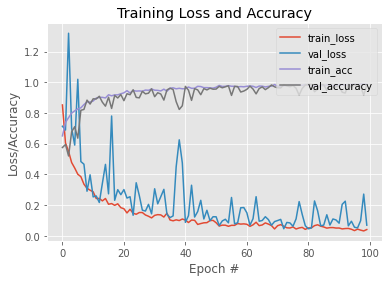

In [ ]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

In [ ]:
prototxtPath=os.path.sep.join(['/content/drive/MyDrive/deploy.prototxt'])
weightsPath=os.path.sep.join(['/content/drive/MyDrive/res10_300x300_ssd_iter_140000.caffemodel'])

In [ ]:
prototxtPath


'/content/drive/MyDrive/deploy.prototxt'

In [ ]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [ ]:
model=load_model('/content/drive/MyDrive/Colab Notebooks/gender_detection.model')

In [ ]:
image=cv2.imread('/content/drive/MyDrive/example_02.png')

In [ ]:

image

array([[[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [169, 169, 169],
        [169, 169, 169],
        [169, 169, 169]],

       [[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [169, 169, 169],
        [169, 169, 169],
        [169, 169, 169]],

       [[235, 235, 235],
        [235, 235, 235],
        [235, 235, 235],
        ...,
        [169, 169, 169],
        [169, 169, 169],
        [169, 169, 169]],

       ...,

       [[169, 169, 169],
        [169, 169, 169],
        [170, 170, 170],
        ...,
        [118, 118, 118],
        [117, 117, 117],
        [116, 116, 116]],

       [[169, 169, 169],
        [169, 169, 169],
        [170, 170, 170],
        ...,
        [116, 116, 116],
        [115, 115, 115],
        [114, 114, 114]],

       [[169, 169, 169],
        [170, 170, 170],
        [170, 170, 170],
        ...,
        [115, 115, 115],
        [113, 113, 113],
        [112, 112, 112]]

In [ ]:
(h,w)=image.shape[:2]

In [ ]:
(h,w)

(400, 400)

In [ ]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [ ]:
blob.shape

(1, 3, 300, 300)

In [ ]:
net.setInput(blob)
detections=net.forward()

In [ ]:
detections

array([[[[0.        , 1.        , 0.99923694, ..., 0.12586218,
          0.6852968 , 0.43432277],
         [0.        , 1.        , 0.1276932 , ..., 4.003238  ,
          4.8399506 , 4.985212  ],
         [0.        , 1.        , 0.12365586, ..., 4.0013595 ,
          0.83174324, 4.9895177 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [ ]:
!pip install cvlib 

     |████████████████████████████████| 10.1MB 6.7MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.6-cp37-none-any.whl size=10044621 sha256=9e7ef579da680d0442314e26f137548b6425c5be0c2f0b8f5e97a83b731d0f42
  Stored in directory: /root/.cache/pip/wheels/5e/a4/99/8dfcae03a6f93bb4084650d0b642ef5a472429928fb95ffd01
  Created wheel for progressbar: filename=progressbar-2.5-cp37-none-any.whl size=12076 sha256=9c1edf1312a0f3ac34735dc6c1925e41507a4f591e36f24481953f7f3a0e60bb
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built cvlib progressbar


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv

In [ ]:
image=cv2.imread('/content/drive/MyDrive/example_02.png')
    
classes = ['man','woman']

# loop through frames

#loop over the detections
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]

    # read frame from webcam 
    
    status, frame = image('/content/drive/MyDrive/example_02.png')
    # apply face detection
    face, confidence = cv.detect_face(frame)


    # loop through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)

   

    # press "Q" to stop
   

# release resources
cv2.imshow("OutPut",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

TypeError: ignored

In [ ]:
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.models import load_model
# import numpy as np
# import cv2
# import os

In [ ]:
# model = load_model('/content/gender_detection.model')

In [ ]:
# webcam = cv2.VideoCapture(0)
# classes = ['Man','Woman']

In [ ]:
# loop through frames
# while webcam.isOpened():

#     # read frame from webcam 
#     status, frame = webcam.read()

#     # apply face detection
#     face, confidence = cv.detect_face(frame)


#     # loop through detected faces
#     for idx, f in enumerate(face):

#         # get corner points of face rectangle        
#         (startX, startY) = f[0], f[1]
#         (endX, endY) = f[2], f[3]

#         # draw rectangle over face
#         cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

#         # crop the detected face region
#         face_crop = np.copy(frame[startY:endY,startX:endX])

#         if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
#             continue

#         # preprocessing for gender detection model
#         face_crop = cv2.resize(face_crop, (96,96))
#         face_crop = face_crop.astype("float") / 255.0
#         face_crop = img_to_array(face_crop)
#         face_crop = np.expand_dims(face_crop, axis=0)

#         # apply gender detection on face
#         conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

#         # get label with max accuracy
#         idx = np.argmax(conf)
#         label = classes[idx]

#         label = "{}: {:.2f}%".format(label, conf[idx] * 100)

#         Y = startY - 10 if startY - 10 > 10 else startY + 10

#         # write label and confidence above face rectangle
#         cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
#                     0.7, (0, 255, 0), 2)

#     # display output
#     cv2.imshow("gender detection", frame)

#     # press "Q" to stop
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # release resources
# webcam.release()
# cv2.destroyAllWindows()